<table class="ee-notebook-buttons" align="center">
    <td><a target="_blank"  href="https://colab.research.google.com/github/ytarazona/scikit-eo/blob/main/examples/01.%20Machine_Learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# **_<div class="alert alert-success"><font color='darkred'> Tutorials: 01 Machine Learning</font></div>_**

# 1.0 Libraries

To install ```scikit-eo``` and ```rasterio``` you can do it with the following line:

In [ ]:
!pip install scikeo rasterio dbfread geopandas

Libraries to be used:

In [2]:
import rasterio
import numpy as np
from scikeo.mla import MLA
from scikeo.process import extract
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from scikeo.plot import plotRGB
from scikeo.writeRaster import writeRaster

Connecting to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 Optical image

Landsat-8 OLI (Operational Land Imager) will be used to obtain in order to classify using Random Forest (RF). This image, which is in surface reflectance with bands:
- Blue -> B2
- Green -> B3
- Red -> B4
- Nir -> B5
- Swir1 -> B6
- Swir2 -> B7

The image and signatures to be used can be downloaded [here](https://drive.google.com/drive/folders/193RhNpACu9THcOZu8OzMh-btnFCOgHrU?usp=sharing):

## 3.0 Supervised Classification using Random Forest

Image and endmembers

In [4]:
path_raster = "/content/drive/MyDrive/Packages/scikit-eo_data/01_machine_learning/LC08_232066_20190727_SR.tif"
img = rasterio.open(path_raster)

# endmembers
path_endm = "/content/drive/MyDrive/Packages/scikit-eo_data/01_machine_learning/endmembers.shp"
endm = gpd.read_file(path_endm)

It is possible extract endmembers values using the ```extract()``` function. In this case, opload only a shapefile (point feature) of samples without spectral values. Here, for instance, some lines of codes how to do it:

In [5]:
# endmembers
endm = extract(img, endm)
endm

,class,band1,band2,band3,band4,band5,band6
0,1.0,646,1137,1446,569,53,33
1,1.0,658,1141,1449,585,68,44
2,1.0,663,1149,1455,573,67,43
3,1.0,657,1147,1453,556,48,29
4,1.0,662,1147,1451,557,52,31
...,...,...,...,...,...,...,...
314,4.0,566,802,1046,2649,3759,2296
315,4.0,403,542,696,2013,2932,1676
316,4.0,622,897,1173,2613,3943,2635
317,4.0,533,772,990,2604,3177,1967


After extracting endmembers values or spectral values let's create a instance object:

Instance of ```mla()```:

In [6]:
inst = MLA(image = img, endmembers = endm)

Applying Random Forest with 80% of data to train

In [7]:
rf_class = inst.RF(training_split = 0.8)

## 4.0 Results

Dictionary of results

In [8]:
rf_class.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

Overall accuracy

In [9]:
rf_class.get('Overall_Accuracy')

0.953125

Kappa index

In [10]:
rf_class.get('Kappa_Index')

0.9365499008592201

Confusion matrix or error matrix

In [11]:
matrix = rf_class.get('Confusion_Matrix')
matrix

,1.0,2.0,3.0,4.0,Total,Users_Accuracy,Commission
1.0,12.0,0.000000,0.0,0.00000,12.0,100.000000,0.000000
2.0,0.0,12.000000,0.0,2.00000,14.0,85.714286,14.285714
3.0,0.0,0.000000,18.0,0.00000,18.0,100.000000,0.000000
4.0,0.0,1.000000,0.0,19.00000,20.0,95.000000,5.000000
Total,12.0,13.000000,18.0,21.00000,NaN,NaN,NaN
Producer_Accuracy,100.0,92.307692,100.0,90.47619,NaN,NaN,NaN
Omission,0.0,7.692308,0.0,9.52381,NaN,NaN,NaN


In [ ]:
# saving this confusion matrix as a .csv file
matrix.to_csv('/content/drive/MyDrive/confusion_matrix.csv', sep = ';', index = True, header=True)

Preparing the image before plotting

In [29]:
# Let's define the color palette
palette = mpl.colors.ListedColormap(['dodgerblue','#e84855','darkgreen','#ADC178'])

Applying the ```plotRGB``` algorithm is easy:

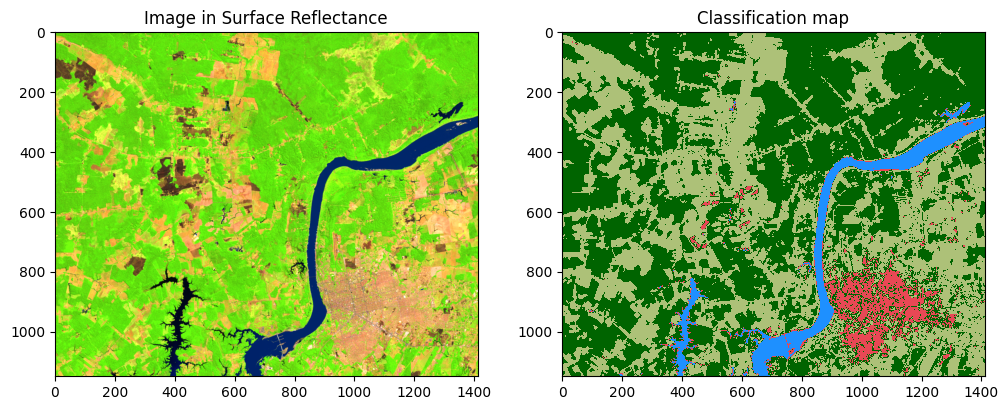

In [30]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 7))

# satellite image
plotRGB(img, bands = [5, 4, 3], title = 'Image in Surface Reflectance', ax = axes[0])

# class results
axes[1].imshow(rf_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)

Finally, it is possible to save our result as raster class (.tif). We will use the ```writeRaster()``` function to do it.

Arguments:
- arr: array of predicted classes
- image: image read by rasterio.open()
- filename: name
- filepath: path to be saved
- n: number of array to be saved. In this case is one because we are only saving one array (2d) with rows and cols.

In [ ]:
writeRaster(arr = rf_class.get('Classification_Map'), image = img, filename = 'LC08_232066_20190727_Label',
   filepath = '/content/drive/MyDrive/Packages/scikit-eo_data/01_machine_learning', n = 1)